In [12]:
import pandas as pd
import numpy as np

% matplotlib inline
import matplotlib.pyplot as plt

from datetime import datetime

from pandas.tseries.offsets import *

import seaborn as sns

## Load all data and do pre-processing

In [2]:
filenames = [ 'raw-data/covis-nas1.txt', \
        'raw-data/covis-nas3.txt', \
        'raw-data/covis-nas5.txt', \
        'raw-data/covis-nas6.txt' ]

fsz = [pd.read_csv(f, delim_whitespace=True, header=None, names=['nas','bytes','filename']) for f in filenames]
files = pd.concat(fsz)

print("Total of %f TB" % (files['bytes'].sum() / 10**12))

ts = pd.DataFrame()
split = files['filename'].str.extract('[\.\/a-zA-Z0-9]*_([0-9T]*)\.[0-9Z\-]*([A-Z]*)', expand=True)

files['datetime'] = pd.to_datetime(split[0], format='%Y%m%dT%H%M%S')
files['datatype'] = split[1]

datatypes = files['datatype'].drop_duplicates().values

before = files.shape[0]
files = files.drop_duplicates(subset='datetime')
print("Dropped %d duplicates" % (before-files.shape[0]) )


## Reindex on datatype and date
files.set_index(['datatype','datetime'], inplace=True)
print(files)


Total of 26.653567 TB
Dropped 26409 duplicates
                              nas       bytes  \
datatype datetime                               
DOPPLER  2011-10-01 09:35:33    1  1625146616   
DIFFUSE  2011-10-01 12:59:23    1     3224599   
         2011-10-01 18:59:31    1     3231845   
DOPPLER  2011-10-01 15:35:34    1  1587003908   
         2011-10-01 12:11:52    1  1581885971   
IMAGING  2011-10-01 18:04:30    1   160634205   
DOPPLER  2011-10-01 21:11:37    1  1614996135   
         2011-10-01 18:35:56    1  1609607342   
DIFFUSE  2011-10-01 01:00:00    1     3140924   
DOPPLER  2011-10-01 06:35:50    1  1637845830   
IMAGING  2011-10-01 21:07:57    1   163650038   
DIFFUSE  2011-10-01 21:59:09    1     3199800   
IMAGING  2011-10-01 06:00:39    1   159311472   
         2011-10-01 03:00:39    1   158660859   
         2011-10-01 09:07:56    1   164401747   
         2011-10-01 00:08:40    1   157726854   
         2011-10-01 12:08:15    1   158609330   
         2011-10-01 03

In [3]:
## For each datatype, collect into days
files['count'] = 1
byday = files.groupby(level=0).apply(lambda x: x.groupby(pd.Grouper(freq='D',level=1)).sum() )
byday.drop('nas', axis=1, inplace=True)

print(byday)

                            bytes  count
datatype datetime                       
DIFFUSE  2011-09-28  2.499177e+07    8.0
         2011-09-29  2.566892e+07    8.0
         2011-09-30  2.507902e+07    8.0
         2011-10-01  2.543424e+07    8.0
         2011-10-02  2.553987e+07    8.0
         2011-10-03  2.553685e+07    8.0
         2011-10-04  2.539754e+07    8.0
         2011-10-05  2.549140e+07    8.0
         2011-10-06  2.548177e+07    8.0
         2011-10-07  2.557170e+07    8.0
         2011-10-08  2.565856e+07    8.0
         2011-10-09  2.569450e+07    8.0
         2011-10-10  2.561548e+07    8.0
         2011-10-11  2.573374e+07    8.0
         2011-10-12  2.574442e+07    8.0
         2011-10-13  2.579521e+07    8.0
         2011-10-14  2.557286e+07    8.0
         2011-10-15  2.552215e+07    8.0
         2011-10-16  2.570812e+07    8.0
         2011-10-17  2.564597e+07    8.0
         2011-10-18  2.589750e+07    8.0
         2011-10-19  2.588366e+07    8.0
         2011-10

Type = DIFFUSE
Mean = 2521314.791790 bytes, stddev = 364465.219388 bytes
     = 2.404513 MiB, 0.347581 MiB


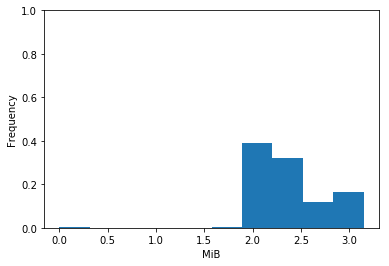

Type = DIFFUSESLOW
Mean = 234270023.000000 bytes, stddev = 636577.462541 bytes
     = 223.417304 MiB, 0.607088 MiB


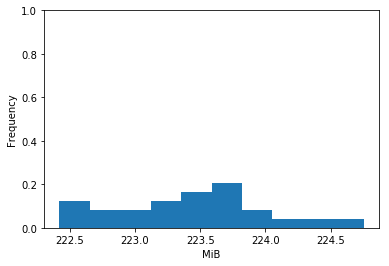

Type = DOPPLER
Mean = 3155286898.672161 bytes, stddev = 518339436.880821 bytes
     = 3009.116076 MiB, 494.327008 MiB


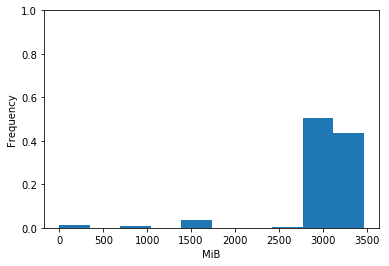

Type = IMAGING
Mean = 482830862.280625 bytes, stddev = 104310348.687680 bytes
     = 460.463393 MiB, 99.478100 MiB


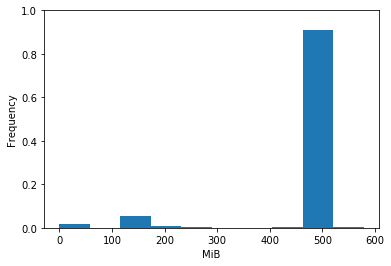

""


In [4]:

def plot_distribution( data ):
    print("Type = %s" % data.index.get_level_values(0).unique()[0])
        
    mean_size = data['bytes'].mean()
    std_size = data['bytes'].std()
    print("Mean = %f bytes, stddev = %f bytes" % (mean_size, std_size) )
    print("     = %f MiB, %f MiB" % (mean_size / 2**20, std_size / 2**20))

    plt.figure()
    weights = np.ones_like(data['bytes'])/float(len(data['bytes']))
    plt.hist( data['bytes']/2**20,normed=False, weights=weights)
    plt.ylim(0.0,1.0)
    plt.ylabel('Frequency')
    plt.xlabel('MiB')
    plt.show()
    
    
files.groupby(level=0).apply(plot_distribution)



In [5]:
## Unstack and resample to bymonth

bymonth = byday.unstack(level=0).resample('M').sum()

#nn =  bymonth.notnull().any(axis=1,bool_only=True)

## Any row which isn't all NA
bymonth = bymonth.dropna(how='all')
    
# Manual
bymonth['bytes','DIFFUSESLOW'][0] = 0
bymonth['count','DIFFUSESLOW'][0] = 0

bymonth.fillna(method='ffill',inplace=True)

bymonth['bytes','total'] = bymonth['bytes'].sum(1)
bymonth['count','total'] = bymonth['count'].sum(1)

## Resample to bring back the NaN
bymonth = bymonth.resample('M').sum()

cumulative = bymonth.cumsum()

print(cumulative)


                   bytes                                              count  \
datatype         DIFFUSE   DIFFUSESLOW       DOPPLER       IMAGING  DIFFUSE   
datetime                                                                      
2011-09-30  7.573972e+07  0.000000e+00  7.740288e+10  1.161155e+10     24.0   
2011-10-31  8.510793e+08  0.000000e+00  8.470713e+11  1.321884e+11    266.0   
2011-11-30  1.250738e+09  0.000000e+00  1.162839e+12  1.960726e+11    391.0   
2011-12-31  2.025001e+09  0.000000e+00  1.493037e+12  3.210774e+11    636.0   
2012-01-31  2.755058e+09  0.000000e+00  2.138055e+12  4.172772e+11    883.0   
2012-02-29  3.429462e+09  0.000000e+00  2.787865e+12  5.094770e+11   1097.0   
2012-03-31  4.212051e+09  0.000000e+00  3.583124e+12  6.351006e+11   1343.0   
2012-04-30  4.972652e+09  0.000000e+00  4.362757e+12  7.576406e+11   1583.0   
2012-05-31  5.623598e+09  0.000000e+00  5.036890e+12  8.633268e+11   1793.0   
2012-06-30  6.363031e+09  0.000000e+00  5.798466e+12

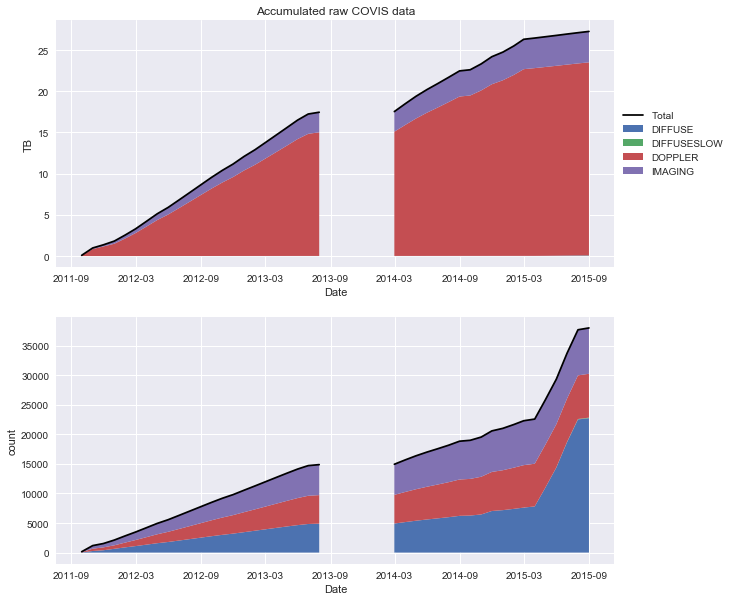

In [13]:
## Plot cumulative values
sns.set()
plt.figure()
# Create a figure with a single subplot
f, ax = plt.subplots(2, figsize=(10,10))

## Make a copy in TB
cumu = cumulative.copy()
cumu['bytes'] /= 10**12

for i,key in enumerate(['bytes','count']):
    
    rowsum = cumu[key].drop('total',axis=1).cumsum(1) 
    
    cols = rowsum.columns.values
    
    ax[i].fill_between(rowsum.index, 0, rowsum[ cols[0] ], label=cols[0])
        
    for j in range(1, len(cols)):
        ax[i].fill_between(rowsum.index, rowsum[ cols[j-1] ], rowsum[ cols[j] ], label=cols[j])


    ax[i].plot(cumu[key].index, cumu[key,'total'],color='k',label='Total')
    ax[i].set_xlabel('Date')
    if i == 0:
        ax[i].set_ylabel('TB')
        ax[i].set_title('Accumulated raw COVIS data')
    else:
        ax[i].set_ylabel('count')
        

ax[0].legend(loc='center left', bbox_to_anchor=(1, 0.5))
    
plt.show()

In [7]:
from datetime import datetime

## Pull out subset for linear regression
subset = cumulative[ datetime(2012,1,1):datetime(2013,6,1) ].copy()
subset['dt'] = (subset.index - subset.index[0]).days

lm = np.polyfit( subset.dt, subset['bytes','total'], 1 )
print(lm)
bytes_per_day = np.asscalar(lm[0])

print("Growth rate %f GB / day" % (bytes_per_day/10**9))

lm = np.polyfit( range( len(subset) ), subset['bytes','total'], 1 )
bytes_per_month = np.asscalar(lm[0])

print("Growth rate %f GB / month" % (bytes_per_month/10**9))


subset = bymonth[ datetime(2012,1,1):datetime(2013,6,1) ]['bytes','total']
print(subset)
mean_per_month = subset.mean()

print("Mean data per month %f" % (mean_per_month/10**9))


[  2.86295396e+10   2.50635427e+12]
Growth rate 28.629540 GB / day
Growth rate 871.305891 GB / month
datetime
2012-01-31    7.419474e+11
2012-02-29    7.426845e+11
2012-03-31    9.216650e+11
2012-04-30    9.029339e+11
2012-05-31    7.804694e+11
2012-06-30    8.834399e+11
2012-07-31    9.228739e+11
2012-08-31    9.277591e+11
2012-09-30    8.970215e+11
2012-10-31    8.671786e+11
2012-11-30    7.575790e+11
2012-12-31    9.240041e+11
2013-01-31    8.168024e+11
2013-02-28    8.316900e+11
2013-03-31    9.267874e+11
2013-04-30    8.970837e+11
2013-05-31    9.346911e+11
Freq: M, Name: (bytes, total), dtype: float64
Mean data per month 863.330047


datetime
2011-09-30    8.909017e+10
2011-10-31    8.910206e+11
2011-11-30    3.800519e+11
2011-12-31    4.559773e+11
2012-01-31    7.419474e+11
2012-02-29    7.426845e+11
2012-03-31    9.216650e+11
2012-04-30    9.029339e+11
2012-05-31    7.804694e+11
2012-06-30    8.834399e+11
2012-07-31    9.228739e+11
2012-08-31    9.277591e+11
2012-09-30    8.970215e+11
2012-10-31    8.671786e+11
2012-11-30    7.575790e+11
2012-12-31    9.240041e+11
2013-01-31    8.168024e+11
2013-02-28    8.316900e+11
2013-03-31    9.267874e+11
2013-04-30    8.970837e+11
2013-05-31    9.346911e+11
2013-06-30    7.395277e+11
2013-07-31    2.169752e+11
2013-08-31    8.633300e+11
2013-09-30    8.633300e+11
2013-10-31    8.633300e+11
2013-11-30    8.633300e+11
2013-12-31    8.633300e+11
2014-01-31    8.633300e+11
2014-02-28    8.214655e+10
2014-03-31    9.564675e+11
2014-04-30    8.943838e+11
2014-05-31    8.166045e+11
2014-06-30    7.183326e+11
2014-07-31    7.665470e+11
2014-08-31    7.818861e+11
2014-09-30    1.373

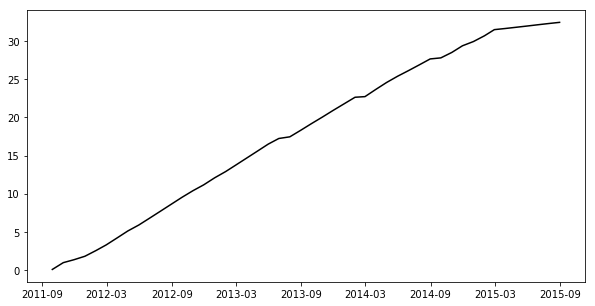

Estimated total data 32.433466


In [8]:


## Try to till in missing data
total = bymonth['bytes','total']
total.fillna( mean_per_month, inplace=True)

print(total)

## Convert to TiB
total /= 10**12

cumu = total.cumsum()

plt.figure()
# Create a figure with a single subplot
f, ax = plt.subplots(1, figsize=(10,5))

## Make a copy in TiB
cumu 

ax.plot(cumu,color='k',label='Total')


plt.show()

print("Estimated total data %f" % cumu.max())


In [9]:
mission_duration = pd.Timedelta(4 * 365)

rng = pd.date_range('7/1/2018', '7/1/2022', freq='M')
data_volume = pd.DataFrame(index=rng)
data_volume['dt'] = data_volume.index - data_volume.index.min()
data_volume['bytes'] = data_volume['dt'].apply(lambda x: x.days) * bytes_per_day
data_volume['tbytes'] = data_volume['bytes'] / 10**12

print(data_volume)

                  dt         bytes     tbytes
2018-07-31    0 days  0.000000e+00   0.000000
2018-08-31   31 days  8.875157e+11   0.887516
2018-09-30   61 days  1.746402e+12   1.746402
2018-10-31   92 days  2.633918e+12   2.633918
2018-11-30  122 days  3.492804e+12   3.492804
2018-12-31  153 days  4.380320e+12   4.380320
2019-01-31  184 days  5.267835e+12   5.267835
2019-02-28  212 days  6.069462e+12   6.069462
2019-03-31  243 days  6.956978e+12   6.956978
2019-04-30  273 days  7.815864e+12   7.815864
2019-05-31  304 days  8.703380e+12   8.703380
2019-06-30  334 days  9.562266e+12   9.562266
2019-07-31  365 days  1.044978e+13  10.449782
2019-08-31  396 days  1.133730e+13  11.337298
2019-09-30  426 days  1.219618e+13  12.196184
2019-10-31  457 days  1.308370e+13  13.083700
2019-11-30  487 days  1.394259e+13  13.942586
2019-12-31  518 days  1.483010e+13  14.830101
2020-01-31  549 days  1.571762e+13  15.717617
2020-02-29  578 days  1.654787e+13  16.547874
2020-03-31  609 days  1.743539e+13

In [10]:
40.940242 * 1.1

45.034266200000005

In [11]:
32.433466 * 1.1

35.676812600000005